# Predict Customer Purchase Behavior Dataset

> **1st project - PPGEEC2318 Machine Learning**

> **Graduate Program in Electrical and Computer Engineering - Department of Computer Engineering and Automation**

> **Professor**: Ivanovitch M. Silva

> **Students**:
>> Leandro Roberto Silva Farias - 20251011748 \\
>> Nicholas Medeiros Lopes - 20251011739

# 0. Initial Steps

## 0.1 Dataset description

# 🛒 Customer Purchase Behavior Prediction

In this notebook, we'll be analyzing **customer purchase behavior** to develop a logistic regression model with Pytorch to predict if a customer will complete a purchase or not.

The **dataset** contains demographic and behavioral information from past customers, including:

- **Age**: Customer's age  
- **Gender**: Customer's gender (0 = Male, 1 = Female)  
- **Annual Income**: Customer's income in dollars  
- **Number of Purchases**: Total past purchases made by the customer  
- **Product Category**: Type of product (0 = Electronics, 1 = Clothing, 2 = Home Goods, 3 = Beauty, 4 = Sports)  
- **Time Spent on Website**: Duration of the customer’s visit, in minutes  
- **Loyalty Program**: Whether the customer is a loyalty program member (0 = No, 1 = Yes)  
- **Discounts Availed**: Number of discounts used (range: 0 to 5)  

The **target variable** is:

- **PurchaseStatus**: Indicates whether the customer **did not purchase (0)** or **did purchase (1)**

This is a **binary classification problem**, with the goal of building a model to predict `PurchaseStatus`. The dataset is balanced, with approximately:

- **0 (No Purchase)**: 48%  
- **1 (Purchase)**: 52%

We'll explore the data, perform preprocessing, visualize patterns, and train predictive models to better understand what drives customer purchasing decisions.


You can download the data from [Kaggle’s Predict Customer Purchase Behavior Dataset](https://www.kaggle.com/datasets/rabieelkharoua/predict-customer-purchase-behavior-dataset).


## 0.2 Download and Import Libraries

The first step of the project was to analyse which libraries were necessary and download/import them to the code.

In [235]:
# Fetch data
import kagglehub
import os

# Data storing and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing and preparation
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, mutual_info_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Model training
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader, WeightedRandomSampler, SubsetRandomSampler
from torch.utils.data.dataset import random_split
import torch.optim as optim
import torch.nn as nn

%matplotlib inline
plt.style.use('fivethirtyeight')

# 1. Extract, Transform and Load (ETL)

## 1.1 Fetch Data

We start by fetching the dataset from the Kaggle website, and storing it in a `csv` file.

In [236]:
# Download latest version of the dataset
path = kagglehub.dataset_download("rabieelkharoua/predict-customer-purchase-behavior-dataset")
print("Path to dataset files:", path)

# List files in the downloaded directory to find the CSV name
print(os.listdir(path))

# Load the CSV file (assuming it's named 'Admission_Predict.csv')
csv_file = os.path.join(path, 'customer_purchase_data.csv')

Path to dataset files: /kaggle/input/predict-customer-purchase-behavior-dataset
['customer_purchase_data.csv']


Then, we load the dataset into a `Pandas` dataframe.

In [237]:
# Load into Pandas
df = pd.read_csv(csv_file)

## 1.2 Exploratory Data Analysis (EDA)

We display the first five columns of dataset to have a first glimpse at it.

In [238]:
# Display the first few rows
df.head()

,Age,Gender,AnnualIncome,NumberOfPurchases,ProductCategory,TimeSpentOnWebsite,LoyaltyProgram,DiscountsAvailed,PurchaseStatus
0,40,1,66120.267939,8,0,30.568601,0,5,1
1,20,1,23579.773583,4,2,38.240097,0,5,0
2,27,1,127821.306432,11,2,31.633212,1,0,1
3,24,1,137798.623120,19,3,46.167059,0,4,1
4,31,1,99300.964220,19,1,19.823592,0,0,1


Then, we get information about the quantity at type of variables.

In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 1500 non-null   int64  
 1   Gender              1500 non-null   int64  
 2   AnnualIncome        1500 non-null   float64
 3   NumberOfPurchases   1500 non-null   int64  
 4   ProductCategory     1500 non-null   int64  
 5   TimeSpentOnWebsite  1500 non-null   float64
 6   LoyaltyProgram      1500 non-null   int64  
 7   DiscountsAvailed    1500 non-null   int64  
 8   PurchaseStatus      1500 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 105.6 KB


We check if there are any null variables on the data set.

In [240]:
df.isnull().sum()

,0
Age,0
Gender,0
AnnualIncome,0
NumberOfPurchases,0
ProductCategory,0
TimeSpentOnWebsite,0
LoyaltyProgram,0
DiscountsAvailed,0
PurchaseStatus,0


We use `Pandas` to have a first numerical description of the dataset.

In [241]:
df.describe()

,Age,Gender,AnnualIncome,NumberOfPurchases,ProductCategory,TimeSpentOnWebsite,LoyaltyProgram,DiscountsAvailed,PurchaseStatus
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,44.298667,0.504667,84249.164338,10.420000,2.012667,30.469040,0.326667,2.555333,0.43200
std,15.537259,0.500145,37629.493078,5.887391,1.428005,16.984392,0.469151,1.705152,0.49552
min,18.000000,0.000000,20001.512518,0.000000,0.000000,1.037023,0.000000,0.000000,0.00000
25%,31.000000,0.000000,53028.979155,5.000000,1.000000,16.156700,0.000000,1.000000,0.00000
50%,45.000000,1.000000,83699.581476,11.000000,2.000000,30.939516,0.000000,3.000000,0.00000
75%,57.000000,1.000000,117167.772858,15.000000,3.000000,44.369863,1.000000,4.000000,1.00000
max,70.000000,1.000000,149785.176481,20.000000,4.000000,59.991105,1.000000,5.000000,1.00000


We change all the column names for low string letters, for pattern purposes.

In [242]:
df.columns = df.columns.str.lower()
df.columns

Index(['age', 'gender', 'annualincome', 'numberofpurchases', 'productcategory',
       'timespentonwebsite', 'loyaltyprogram', 'discountsavailed',
       'purchasestatus'],
      dtype='object')

Then, we separate which features are categorical and which ones are numerical.

In [243]:
categorical_features = ['gender', 'productcategory', 'loyaltyprogram', 'purchasestatus']
numerical_features = [col for col in df.columns if col not in categorical_features]

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

Numerical features: ['age', 'annualincome', 'numberofpurchases', 'timespentonwebsite', 'discountsavailed']
Categorical features: ['gender', 'productcategory', 'loyaltyprogram', 'purchasestatus']


We map the variables of the dataset to labels to improve readability.

In [244]:
gender_values = {
    0: 'male',
    1: 'female'
}

df.gender = df.gender.map(gender_values)

productcategory_values = {
    0: 'electronics',
    1: 'clothing',
    2: 'homegoods',
    3: "beauty",
    4: "sports"
}

df.productcategory = df.productcategory.map(productcategory_values)

loyaltyprogram_values = {
    0: 'no',
    1: 'yes'
}

df.loyaltyprogram = df.loyaltyprogram.map(loyaltyprogram_values)


purchasestatus_values = {
    0: 'no',
    1: 'yes'
}

df.purchasestatus = df.purchasestatus.map(purchasestatus_values)

We start the EDA by printing the unique values of each feature.

In [245]:
for col in df.columns:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique())
    print()

age
[40 20 27 24 31]
53

gender
['female' 'male']
2

annualincome
[ 66120.26793868  23579.77358303 127821.30643165 137798.62311955
  99300.96422033]
1388

numberofpurchases
[ 8  4 11 19 14]
21

productcategory
['electronics' 'homegoods' 'beauty' 'clothing' 'sports']
5

timespentonwebsite
[30.56860116 38.24009661 31.6332115  46.16705881 19.82359186]
1388

loyaltyprogram
['no' 'yes']
2

discountsavailed
[5 0 4 2 3]
6

purchasestatus
['yes' 'no']
2



We then use `Seaborn` to plot an histogram for the numerical features.

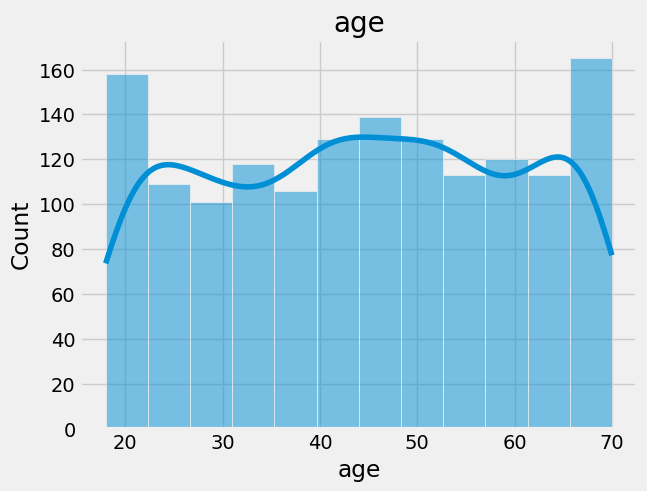

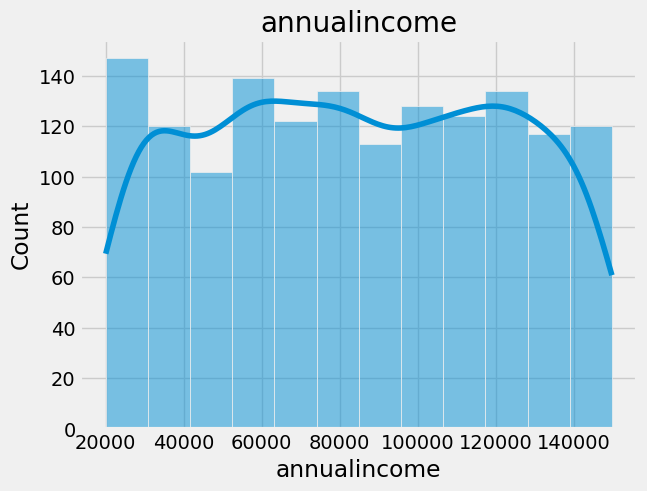

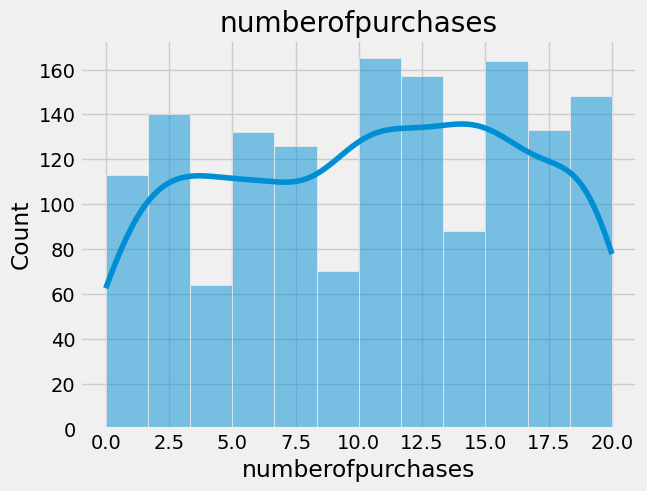

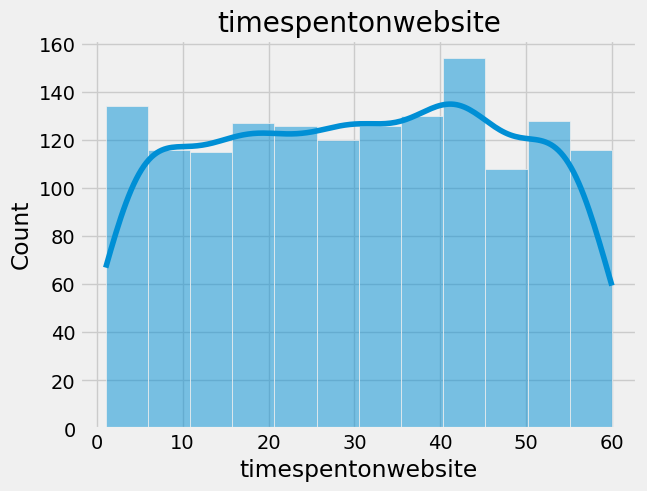

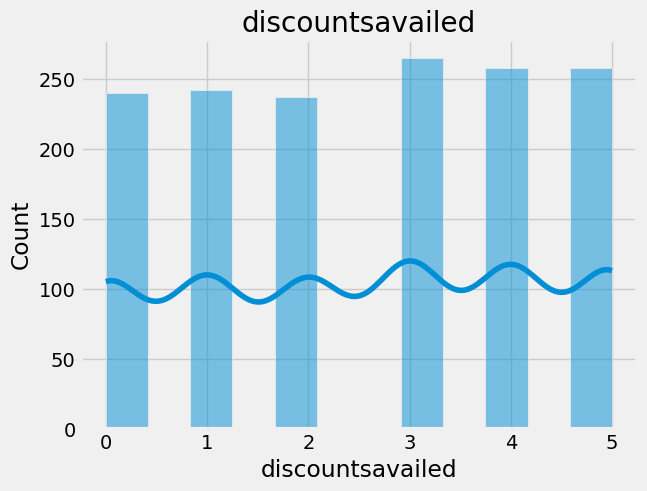

In [246]:
# Draw a histogram and add the kernel density estimation curve (KDE Curve)
for col in numerical_features:
    sns.histplot(df[col], kde=True) # Draw a histogram, use KDE to smooth data distribution
    plt.title(col)
    plt.show()

And then we do the same for the categorical features.

Column: gender, Unique values: 2


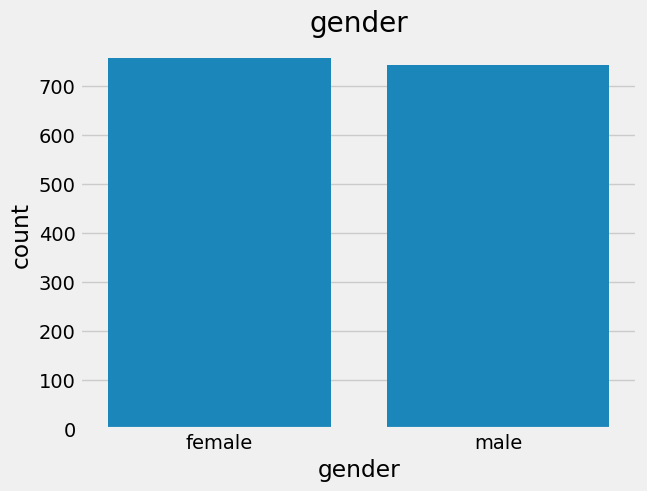

Column: productcategory, Unique values: 5


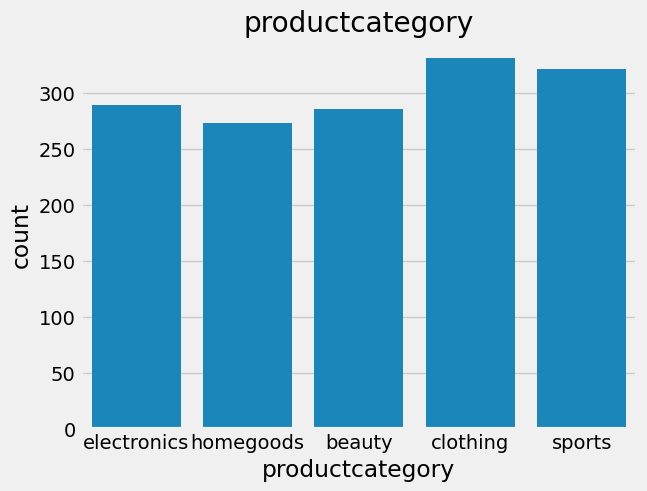

Column: loyaltyprogram, Unique values: 2


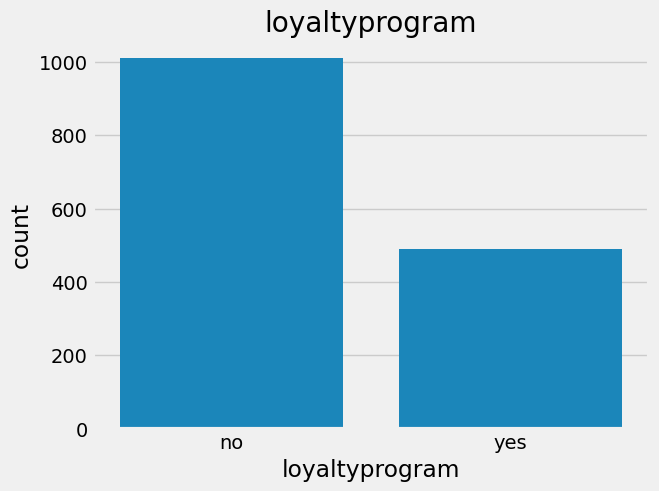

Column: purchasestatus, Unique values: 2


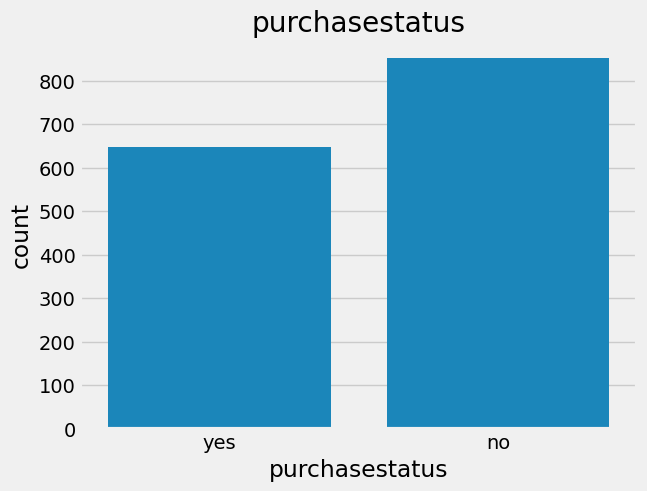

In [247]:
for col in categorical_features:
    print(f'Column: {col}, Unique values: {df[col].nunique()}')
    sns.countplot(x=col, data=df)
    plt.title(col)
    plt.show()

We the use `mutual_info_score` to calculate how linear correlated each feature is to the target variable.

In [248]:
df[categorical_features].apply(lambda x: mutual_info_score(x, df.purchasestatus)).sort_values()

,0
gender,0.000003
productcategory,0.001016
loyaltyprogram,0.048528
purchasestatus,0.683870


In [249]:
df[numerical_features].apply(lambda x: mutual_info_score(x, df.purchasestatus)).sort_values()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


,0
numberofpurchases,0.047945
age,0.061679
discountsavailed,0.062417
annualincome,0.683870
timespentonwebsite,0.683870


## 1.3 Preprocessing

After the EDA, we notice that the dataset is balanced with no missing variables. So the only preprocessing we decided to do is to drop the `gender` and `productcategory` features, since it was visible from the EDA that they are not correlated with the target variable

In [250]:
# Remove chosen columns from the dataset
#columns_to_drop = ['gender', "productcategory", 'numberofpurchases']
columns_to_drop = ['gender', "productcategory"]
model_inputs = 8 - len(columns_to_drop)
df = df.drop(columns_to_drop, axis=1)

In [251]:
# Show the modified dataset
df.head()

,age,annualincome,numberofpurchases,timespentonwebsite,loyaltyprogram,discountsavailed,purchasestatus
0,40,66120.267939,8,30.568601,no,5,yes
1,20,23579.773583,4,38.240097,no,5,no
2,27,127821.306432,11,31.633212,yes,0,yes
3,24,137798.623120,19,46.167059,no,4,yes
4,31,99300.964220,19,19.823592,no,0,yes


In [252]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 1500 non-null   int64  
 1   annualincome        1500 non-null   float64
 2   numberofpurchases   1500 non-null   int64  
 3   timespentonwebsite  1500 non-null   float64
 4   loyaltyprogram      1500 non-null   object 
 5   discountsavailed    1500 non-null   int64  
 6   purchasestatus      1500 non-null   object 
dtypes: float64(2), int64(3), object(2)
memory usage: 82.2+ KB


# 2. Data Preparation

## 2.1 Split Dataset (Training/Validation)

We start data preparating by spliting the data into training and validation sets. Due to the dataset small size (1500 lines), we decided not to use a test dataset.

We used a 80/20 division.

In [253]:
# Ratio used to split train and validation data
val_size = 0.20

# Seed used to reproduce purposes
seed = 41

# Reference (column) to stratify the data
stratify = "purchasestatus"

# Split-out train/validation dataset
x_train, x_val, y_train, y_val = train_test_split(df.drop(labels=stratify,axis=1),
                                                  df[stratify],
                                                  test_size=val_size,
                                                  random_state=seed,
                                                  shuffle=True,
                                                  stratify=df[stratify])

In [254]:
print("x train: {}".format(x_train.shape))
print("y train: {}".format(y_train.shape))
print("x val: {}".format(x_val.shape))
print("y val: {}".format(y_val.shape))

x train: (1200, 6)
y train: (1200,)
x val: (300, 6)
y val: (300,)


## 2.2 Encode Target Variable

In [255]:
y_train.head(10)

,purchasestatus
1361,yes
62,yes
1394,no
1467,no
716,no
945,yes
45,no
613,yes
85,no
723,yes


In [256]:
## Encode target variable manually: 'Non-admit' → 0, 'Admit' → 1
print("Encoding Target Variable")

# Apply mapping to both train and validation sets
y_train = y_train.map({'no': 0, 'yes': 1})
y_val = y_val.map({'no': 0, 'yes': 1})

# Check that encoding is correct
print("Classes [0, 1] correspond to: {0}".format(['no', 'yes']))
print("y_train unique values:", y_train.unique())
print("y_val unique values:", y_val.unique())


Encoding Target Variable
Classes [0, 1] correspond to: ['no', 'yes']
y_train unique values: [1 0]
y_val unique values: [1 0]


In [257]:
y_train.head(10)

,purchasestatus
1361,1
62,1
1394,0
1467,0
716,0
945,1
45,0
613,1
85,0
723,1


In [258]:
y_val.head(10)

,purchasestatus
90,1
704,1
1006,1
1319,0
247,0
600,0
15,0
848,1
431,1
157,0


In [259]:
count_train = 0
for i in range(len(y_train)):
    if y_train.iloc[i] == 1:
        count_train += 1

count_val = 0
for i in range(len(y_val)):
    if y_val.iloc[i] == 1:
        count_val += 1

count_total = 0
for i in range(len(df["purchasestatus"])):
    if df["purchasestatus"].iloc[i] == "yes":
        count_total += 1

print("Number of 1s in y_train:", count_train)
print("Number of 1s in y_val:", count_val)
print("Number of 1s in y:", count_total)

Number of 1s in y_train: 518
Number of 1s in y_val: 130
Number of 1s in y: 648


## 2.3 Encode Independent Variables

### 2.3.1 Categorical Variables

In [260]:
# One-hot encode object columns
for name in x_train.select_dtypes("object").columns:
    onehot = OneHotEncoder(sparse_output=False, drop="first")

    # Fit encoder on training data
    onehot.fit(x_train[[name]])

    # Transform and assign back
    x_train[onehot.get_feature_names_out([name])] = onehot.transform(x_train[[name]])
    x_val[onehot.get_feature_names_out([name])] = onehot.transform(x_val[[name]])

# Drop original categorical columns (after encoding)
cols_to_drop = ['loyaltyprogram']
x_train.drop(columns=cols_to_drop, inplace=True)
x_val.drop(columns=cols_to_drop, inplace=True)

# View the transformed data
x_train.head()

,age,annualincome,numberofpurchases,timespentonwebsite,discountsavailed,loyaltyprogram_yes
1361,29,122498.154623,12,18.131351,5,0.0
62,52,116034.009594,0,21.420402,3,1.0
1394,45,149200.290557,7,59.960841,1,0.0
1467,68,80311.223269,14,19.080098,3,0.0
716,64,146645.277696,15,49.297001,2,0.0


### 2.3.2 Numerical Variables

In [261]:
scaler = StandardScaler()

# Fit on training data
#x_train[['age', 'numberofpurchases', 'annualincome', 'timespentonwebsite', 'discountsavailed']] = scaler.fit_transform(x_train[['age', 'numberofpurchases', 'annualincome', 'timespentonwebsite', 'discountsavailed']])
x_train[['age', 'annualincome', 'timespentonwebsite', 'discountsavailed']] = scaler.fit_transform(x_train[['age', 'annualincome', 'timespentonwebsite', 'discountsavailed']])

# Apply transformation on validation data
#x_val[['age', 'numberofpurchases', 'annualincome', 'timespentonwebsite', 'discountsavailed']] = scaler.transform(x_val[['age', 'numberofpurchases', 'annualincome', 'timespentonwebsite', 'discountsavailed']])
x_val[['age','annualincome', 'timespentonwebsite', 'discountsavailed']] = scaler.transform(x_val[['age', 'annualincome', 'timespentonwebsite', 'discountsavailed']])

# View the transformed data
x_train.head()

,age,annualincome,numberofpurchases,timespentonwebsite,discountsavailed,loyaltyprogram_yes
1361,-0.982174,1.004193,12,-0.754658,1.454115,0.0
62,0.502057,0.832311,0,-0.560062,0.267889,1.0
1394,0.050335,1.714208,7,1.720179,-0.918336,0.0
1467,1.534566,-0.117564,14,-0.698526,0.267889,0.0
716,1.276439,1.646269,15,1.089254,-0.325223,0.0


# 3. Training

For the training part, we will use the the logistic regression architecture studied in class.

## 3.1 Import Architecture from Week 05 Lecture

In [262]:
# This architecture was taken from the Week 05 lecture by Ivanovitch
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename,weights_only=False)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

## 3.2 Create PyTorch Tensors

We create PyTorch tensors based on our training and validatiosn sets.

In [263]:
torch.manual_seed(41)

# Convert Pandas DataFrames/Series to tensors
x_train_tensor = torch.tensor(x_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy().reshape(-1, 1), dtype=torch.float32)

x_val_tensor = torch.tensor(x_val.to_numpy(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.to_numpy().reshape(-1, 1), dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Create DataLoaders
#train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

## 3.3 Model Configuration

We configurate the model to a logistic regression.

In [264]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.01

torch.manual_seed(41)
model = nn.Sequential()
model.add_module('linear', nn.Linear(model_inputs, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

## 3.4 Training

In [265]:
n_epochs = 500

arch = Architecture(model, loss_fn, optimizer)
arch.set_loaders(train_loader, val_loader)
arch.set_seed(41)
arch.train(n_epochs)

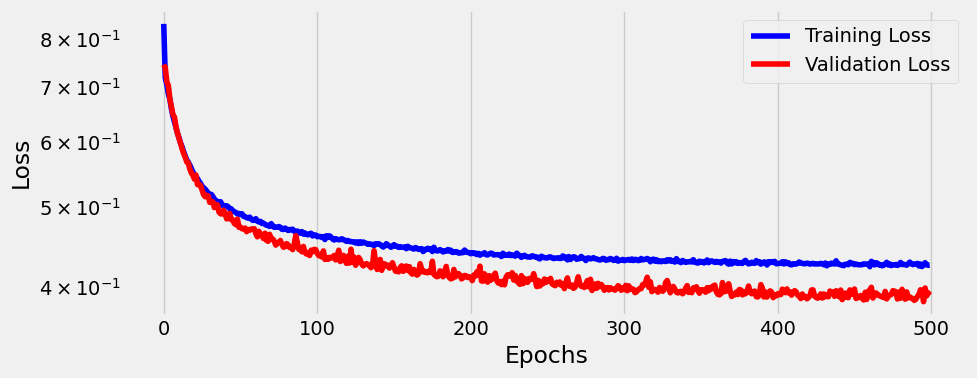

In [266]:
fig = arch.plot_losses()

# 4. Model evaluation

## 4.1 Model Architecture

In [267]:
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[-0.9121,  0.6209,  0.0807,  0.8997,  1.0192,  1.9651]])), ('linear.bias', tensor([-1.9273]))])


## 4.2 Prediction example

In [268]:
# prediction logits (z)
logits_val = arch.predict(x_val[:4].to_numpy())
logits_val

array([[-0.89994377],
       [ 0.6931521 ],
       [ 2.2161403 ],
       [ 0.51145893]], dtype=float32)

In [269]:
# prediction probabilities
prob_val = torch.sigmoid(torch.as_tensor(logits_val[:4]).float())
prob_val

tensor([[0.2891],
        [0.6667],
        [0.9017],
        [0.6251]])

In [270]:
classes = (prob_val >= 0.5).to(torch.int8)
classes

tensor([[0],
        [1],
        [1],
        [1]], dtype=torch.int8)

## 4.3 Complete evaluation on validation set

In [271]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [272]:
logits_val = arch.predict(x_val.to_numpy())
probabilities_val = sigmoid(logits_val).squeeze()
threshold = 0.5

In [273]:
def probability_line(ax, y, probs, threshold, shift=0.0, annot=False, colors=None):
    if colors is None:
        colors = ['r', 'b']
    ax.grid(False)
    ax.set_ylim([-.1, .1])
    ax.axes.get_yaxis().set_visible(False)
    ax.plot([0, 1], [0, 0], linewidth=2, c='k', zorder=1)
    ax.plot([0, 0], [-.1, .1], c='k', zorder=1)
    ax.plot([1, 1], [-.1, .1], c='k', zorder=1)

    tn = (y == 0) & (probs < threshold)
    fn = (y == 0) & (probs >= threshold)
    tp = (y == 1) & (probs >= threshold)
    fp = (y == 1) & (probs < threshold)

    ax.plot([threshold, threshold], [-.1, .1], c='k', zorder=1, linestyle='--')
    ax.scatter(probs[tn], np.zeros(tn.sum()) + shift, c=colors[0], s=150, zorder=2, edgecolor=colors[0], linewidth=3)
    ax.scatter(probs[fn], np.zeros(fn.sum()) + shift, c=colors[0], s=150, zorder=2, edgecolor=colors[1], linewidth=3)

    ax.scatter(probs[tp], np.zeros(tp.sum()) - shift, c=colors[1], s=150, zorder=2, edgecolor=colors[1], linewidth=3)
    ax.scatter(probs[fp], np.zeros(fp.sum()) - shift, c=colors[1], s=150, zorder=2, edgecolor=colors[0], linewidth=3)

    ax.set_xlabel(r'$\sigma(z) = P(y=1)$')
    ax.set_title('Threshold = {}'.format(threshold))

    if annot:
        ax.annotate('TN', xy=(.20, .03), c='k', weight='bold', fontsize=20)
        ax.annotate('FN', xy=(.20, -.08), c='k', weight='bold', fontsize=20)
        ax.annotate('FP', xy=(.70, .03), c='k', weight='bold', fontsize=20)
        ax.annotate('TP', xy=(.70, -.08), c='k', weight='bold', fontsize=20)
    return ax

In [274]:
def figure10(y, probabilities, threshold, shift, annot, colors=None):
    fig, ax = plt.subplots(1, 1, figsize=(10, 2))
    probability_line(ax, y, probabilities, threshold, shift, annot, colors)
    fig.tight_layout()
    return fig

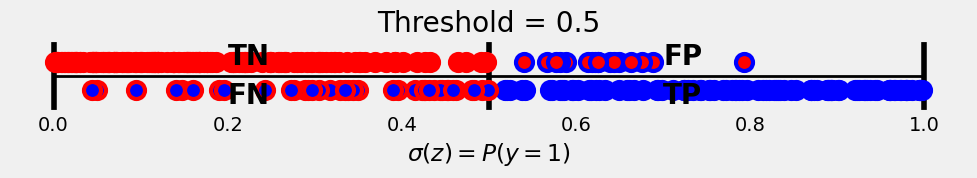

In [275]:
fig = figure10(y_val, probabilities_val, threshold, 0.04, True)

In [276]:
def split_cm(cm):
    # Actual negatives go in the top row,
    # above the probability line
    actual_negative = cm[0]
    # Predicted negatives go in the first column
    tn = actual_negative[0]
    # Predicted positives go in the second column
    fp = actual_negative[1]

    # Actual positives go in the bottow row,
    # below the probability line
    actual_positive = cm[1]
    # Predicted negatives go in the first column
    fn = actual_positive[0]
    # Predicted positives go in the second column
    tp = actual_positive[1]

    return tn, fp, fn, tp

def tpr_fpr(cm):
    tn, fp, fn, tp = split_cm(cm)

    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    return tpr, fpr

def precision_recall(cm):
    tn, fp, fn, tp = split_cm(cm)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    return precision, recall

In [277]:
logits_val = arch.predict(x_val.to_numpy())
probabilities_val = sigmoid(logits_val).squeeze()
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= 0.5))
cm_thresh50

array([[153,  17],
       [ 39,  91]])

In [278]:
precision_recall(cm_thresh50)

(np.float64(0.8425925925925926), np.float64(0.7))

In [279]:
acc = accuracy_score(y_val, (probabilities_val >= 0.5))
acc

0.8133333333333334

In [280]:
tpr_fpr(cm_thresh50)

(np.float64(0.7), np.float64(0.1))